In [63]:
%matplotlib inline

In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

target_k = [5,10,30,65,100]


def run_knn(results, X_encoded, Y, file_name):
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_encoded)
    
    # Split
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

    bestmodel = None
    bestscore = -1
    bestk = 1
    for k in target_k:
        # Train model
        model = KNeighborsClassifier(n_neighbors=k)
        model.fit(X_train, y_train)
        
        # Predict
        y_pred = model.predict(X_test)
        
        # Evaluate
        print("Results with K neighbors: ", k)
        acc = round(accuracy_score(y_test, y_pred),2)
        print("accuracy:", acc)

        cm = confusion_matrix(y_test, y_pred)

        if acc > bestscore:
            bestscore = acc
            bestmodel = model
            bestk = k
        
        results[k] = (acc, cm)

    if bestmodel != None:
        print("Best score found with K neighbors: ", bestk)
        # Get feature names
        feature_names = X_encoded.columns
        
        # Compute permutation importances
        result = permutation_importance(bestmodel, X_test, y_test, n_repeats=5, n_jobs=-1, random_state=42)
        
        # Display results
        importances = result.importances_mean
        sorted_idx = importances.argsort()
        
        plt.figure(figsize=(8, 6))
        plt.barh(range(len(sorted_idx)), importances[sorted_idx], align='center')
        plt.yticks(range(len(sorted_idx)), feature_names[sorted_idx])
        plt.xlabel("Permutation Importance")
        plt.title("Feature Importance (Permutation Method)")
        
        plt.savefig(file_name + "f_imp.png", bbox_inches='tight')
        plt.show()

        plt.figure(figsize=(8, 10))
        disp = ConfusionMatrixDisplay(confusion_matrix=results[bestk][1], display_labels=bestmodel.classes_)
        disp.plot(cmap='Blues')
        plt.savefig(file_name + "conf.png", bbox_inches='tight')
        plt.title("KNN Confusion Matrix")
        plt.show()


def graph_knn_results(results_arr, file_name_base, results_names = None):
    plt.figure(figsize=(6, 5))

    i = 0
    for r_dict in results_arr:
        x_arr = []
        y_arr = []
        for k, v in r_dict.items():
            x_arr.append(k)
            y_arr.append(v[0])
            
        if results_names:
            plt.plot(x_arr, y_arr, marker='o', linestyle='-', linewidth=2, label=results_names[i])
            i += 1
        else:
            plt.plot(x_arr, y_arr,  marker='o', linestyle='-', linewidth=2)

    plt.title('Accuracy vs K')
    plt.xlabel('K')
    plt.ylabel('Accuracy Score')

    if results_names:
        plt.legend()

    plt.tight_layout()
    plt.savefig(file_name_base, bbox_inches='tight')
    plt.show()

Results with K neighbors:  5
accuracy: 0.1
Results with K neighbors:  10
accuracy: 0.1
Results with K neighbors:  30
accuracy: 0.1
Results with K neighbors:  65
accuracy: 0.1
Results with K neighbors:  100
accuracy: 0.1
Best score found with K neighbors:  5


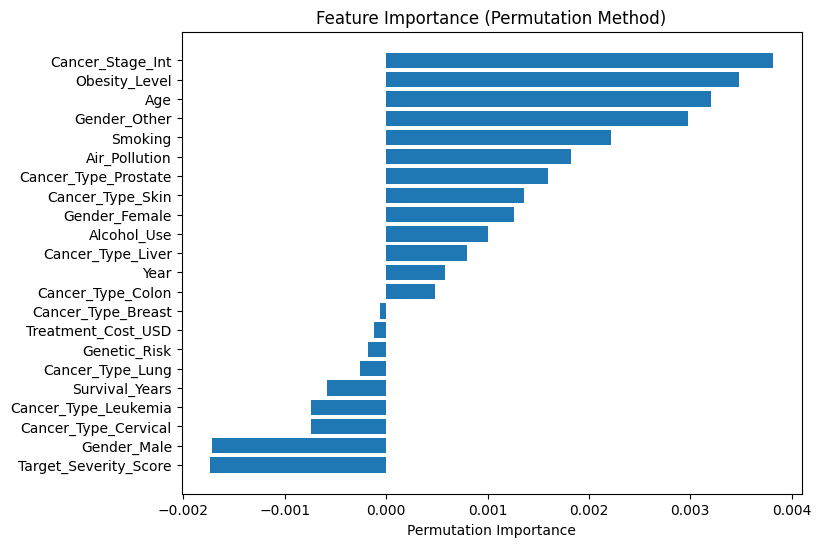

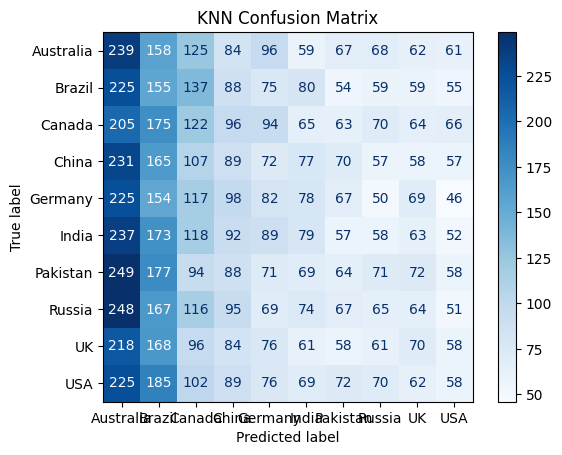

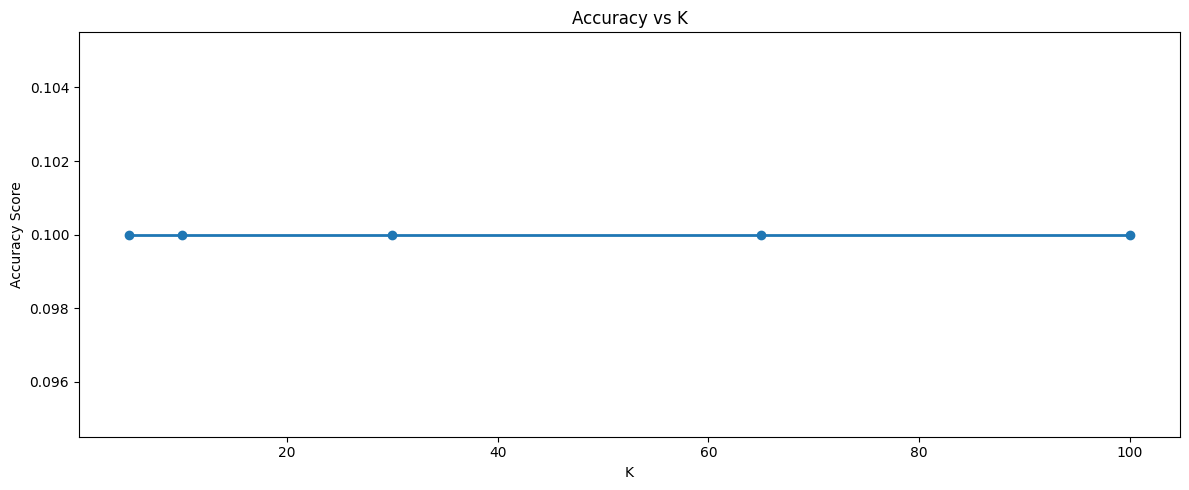

In [10]:
# Experiment 1 - Full Dataset

import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Load CSV
df = pd.read_csv('global_cancer_patients_2015_2024.csv')

# Normalize year
df['Year'] = 2025 - df['Year']

# Encode the combined labels
label_encoder = LabelEncoder()
df['Cancer_Stage_Int'] = label_encoder.fit_transform(df['Cancer_Stage'])

# Save mapping (optional)
label_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))

# One-hot encode categorical features
categorical_cols = ['Gender','Cancer_Type']
X = pd.get_dummies(df, columns=categorical_cols)

# Drop original target columns
Y = X['Country_Region']
X = X.drop(['Patient_ID', 'Country_Region', 'Cancer_Stage'], axis=1)  # drop ID and target

# Run the algorithm
full_results = {}
run_knn(full_results, X, Y, "cancer_knn_all_features")
graph_knn_results([full_results], "cancer_knn_all_features_permutation")

Results with K neighbors:  5
accuracy: 0.1
Results with K neighbors:  10
accuracy: 0.1
Results with K neighbors:  30
accuracy: 0.11
Results with K neighbors:  65
accuracy: 0.1
Results with K neighbors:  100
accuracy: 0.1
Best score found with K neighbors:  30


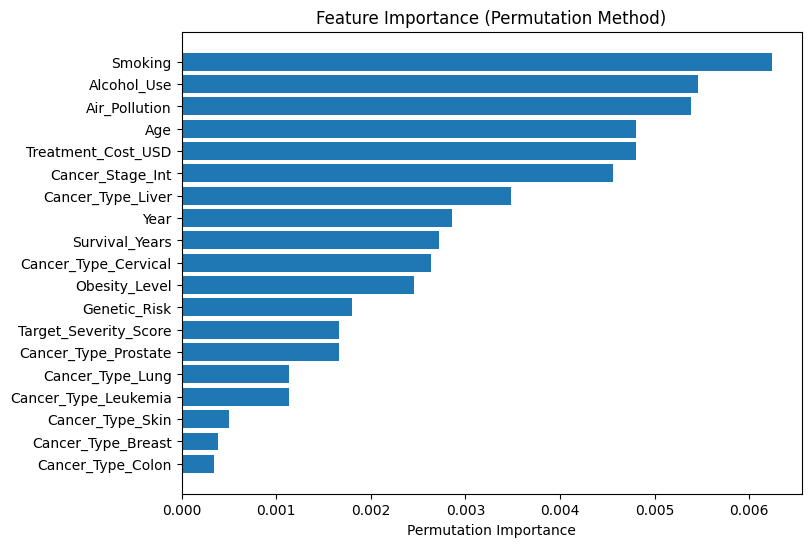

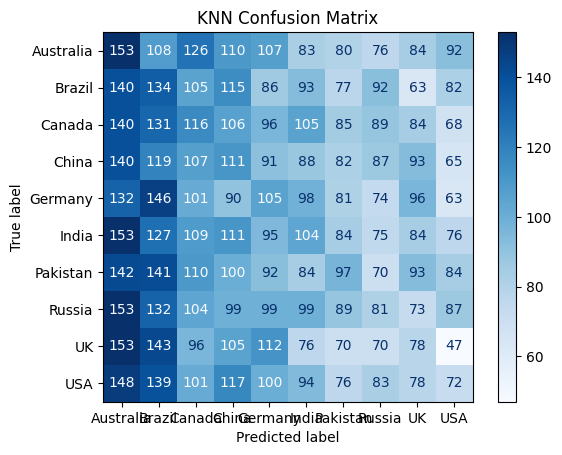

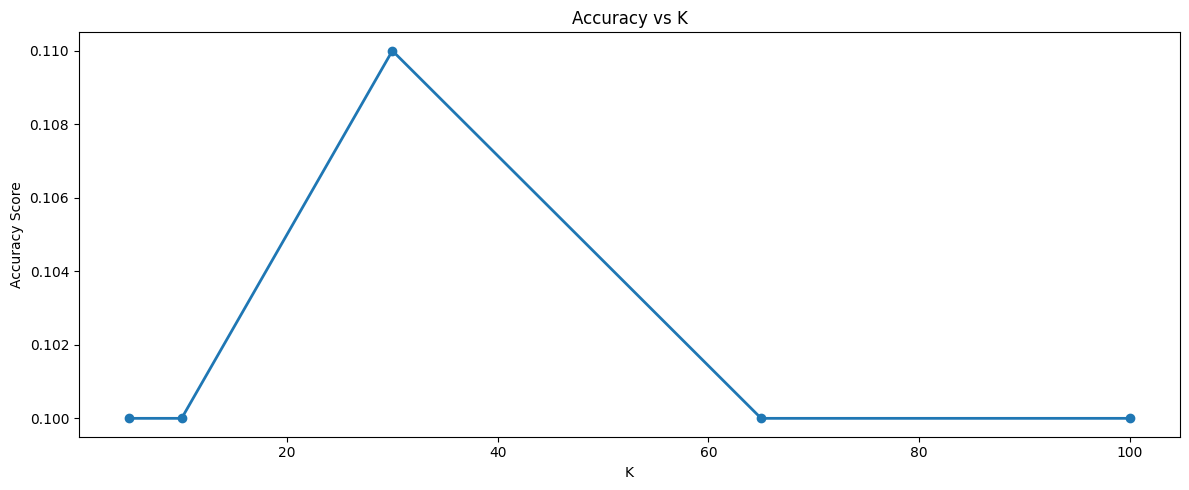

In [15]:
# Experiment 2 - No Score and Gender

import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Load CSV
df = pd.read_csv('global_cancer_patients_2015_2024.csv')

# Normalize year
df['Year'] = 2025 - df['Year']

# Encode the combined labels
label_encoder = LabelEncoder()
df['Cancer_Stage_Int'] = label_encoder.fit_transform(df['Cancer_Stage'])

# Save mapping (optional)
label_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))

X = df
# One-hot encode categorical features
categorical_cols = ['Cancer_Type']
X = pd.get_dummies(df, columns=categorical_cols)

# Drop original target columns
Y = X['Country_Region']
X = X.drop(['Patient_ID', 'Country_Region', 'Cancer_Stage','Gender'], axis=1)  # drop ID and target

# Run the algorithm
no_score_gender = {}
run_knn(no_score_gender, X, Y, "cancer_knn_no_onehot.")
graph_knn_results([no_score_gender], "cancer_knn_no_onehot_permutation.png")

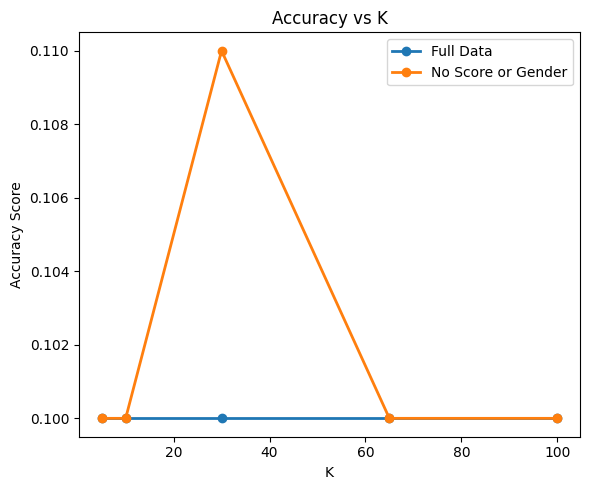

In [17]:
# Cumulating all the results onto one graph
graph_knn_results([full_results,no_score_gender], "cancer_knn_cumulative.png", ["Full Data", "No Score or Gender"])
